# Sensitivity Analysis for Single Objective Optimization

In [1]:
from wpaf_opt import *
import math
import time

def ratio_finder(f):
    # Perturbation Size Δx Choice based on Gill et. al. 1983
    eps = 1e-4
    delta_X = math.sqrt(eps / abs(f))
    
    #print('\ndelta_X= ', "{:1.2f}".format(delta_X*100), '%')
    ratios = [1-delta_X/2, 1, 1+delta_X/2]
    #print('ratios=',ratios)
    return ratios

def sensitivity_analysis(x, res_best, p):
    print('Sensitivity of objective function to optimal design variables (Identify key driver):\n')

    wpaf_obj = WPAF(res_best.x, x.name, p) 
    x_list, x_nom, x_unit, x_bnds, x_label = optimization.default_value(x.name)
    res_list = ['cost_per_fishyield', 'cost', 'levelized_fishyield']

    x_ratios = ratio_finder(res_best.fun)
    f = np.zeros(shape=(len(wpaf_obj.x0),len(x_ratios), len(res_list)))
    df_dxstar = np.zeros(shape=(len(wpaf_obj.x0), len(res_list)))

    for x_idx in range(len(wpaf_obj.x0)):
        for ratio_idx in range(len(x_ratios)):
            x_sweep = copy.deepcopy(wpaf_obj.x0)
            x_sweep[x_idx] = x_sweep[x_idx] * x_ratios[ratio_idx]
            wpaf_obj_i = WPAF(x_sweep, wpaf_obj.x_name, wpaf_obj.p) 

            f[x_idx, ratio_idx, :] = [wpaf_obj_i.obj_func, wpaf_obj_i.cost_NPV, wpaf_obj_i.levelized_fish_yield]

        idx_nom = x_ratios.index(1)

        #suppose we have x_sweep = [x*-eps, x*, x*+eps]
        #df = ((f[x* + eps] - f[x*]) - (f[x*] - f[x* - eps])) / f[x*]
        #dxstar = ((x* + eps -x*) - (x* - x* - eps)) / x*
        #We calculate df / dxstar here:
        df = np.divide((f[x_idx,-1,:] - f[x_idx,0,:]), f[x_idx,idx_nom,:])
        df_dxstar[x_idx,:] = df / (x_ratios[-1] - x_ratios[0])    
    
    # print result in a table format
    col_width = len(max(x_list+res_list, key=len)) + 1
    print(' '*col_width, end='')
    for i in range(len(res_list)):
        print(' ',res_list[i], ' '*(col_width-len(res_list[i])-2),end='')
    print('')
    for i in range(len(x_list)):
        #print the row title
        print(x_list[i],end='')
        print('*', ' '*(col_width-len(x_list[i])),end='|')
        for j in range(len(res_list)):
            #print the values
            if (df_dxstar[i,j] == 0):
                print('  0', ' '*(col_width-4),end='|')
            elif np.isnan(df_dxstar[i,j]):
                print("  \x1b[31mFailed\x1b[0m", ' '*(col_width-9),end='|')
            else:
                print("{:10.6f}".format(df_dxstar[i,j]), ' '*(col_width-11),end='|')
        print('')
     
    return df_dxstar, x_list, res_list


#find the optimal solution
x_init, p_init, x, res_best, p_best, op_obj = wpaf_single_opt()

start_time = time.time()

df_dxstar, x_list, res_list= sensitivity_analysis(x, res_best, p_best)

print('\nExecution time:', time.time() - start_time, 'seconds')
timestr = time.strftime("%Y%m%d_%H%M%S")

Sensitivity of objective function to optimal design variables (Identify key driver):

                      cost_per_fishyield   cost                 levelized_fishyield 
capture_width*        | -0.088422          | -0.088422          |  0                 |
pen_diameter*         |  0.238793          |  3.414733          |  3.172687          |
stock_density*        |  0.033558          |  1.033854          |  1.000000          |

Execution time: 0.9256279468536377 seconds


# Plot Sensitivity Analysis Results

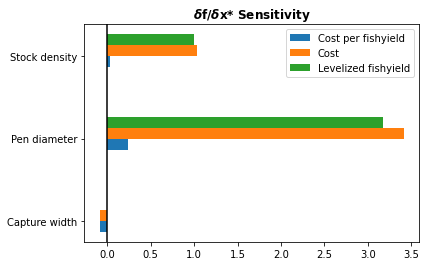

In [2]:
import matplotlib.pyplot as plt

def plot_sensitivity(results, x_label, y_label):
    fs = 12
    ax = plt.subplot(111)
    dim = len(results[0])
    w = 0.4
    dimw = w / dim    
    
    x_label = list(map(lambda st: str.replace(st, '_', ' '), x_label))
    y_label = list(map(lambda st: str.replace(st, '_', ' '), y_label))
    x_label = [label.capitalize() for label in x_label]
    y_label = [label.capitalize() for label in y_label]

    x = np.arange(len(results))
    
    for i in range(len(results[0])):
        y = [d[i] for d in results]
        b = ax.barh(x + i * dimw, y,
                    dimw, left = 0.001)
  
    ax.set_yticks(x + dimw / 2)
    ax.set_yticklabels(y_label)    
    ax.legend(x_label) #, loc='upper left' # title="title"
    Title =  '$\delta$f/$\delta$x* Sensitivity'
    ax.set_title(Title, fontsize = fs, fontweight = 'bold')

    ax.axvline(0, color="k")
    
    font = {'weight': 'bold',
            'size': fs}    
    plt.rc('font', **font)

    plt.savefig('archived_results/sensitivity_analysis/sensitivity_' + timestr + '.pdf', bbox_inches = "tight")
    plt.savefig('results/sensitivity_analysis/sensitivity.pdf' )
    plt.savefig('results/sensitivity_analysis/sensitivity.png', bbox_inches = "tight")

plot_sensitivity(df_dxstar, res_list, x_list)